# TF-MInDi on Mouse Cortex

To illustrate how TF-MInDi works we calculated contribution scores for the top 2000 most specific regions for every cell type of the mouse cortex using 
`CREsted`'s DeepBICCN2 model (see [the model](https://crested.readthedocs.io/en/latest/models/BICCN/deepbiccn2.html) and [specific contribution scores](https://crested.readthedocs.io/en/latest/api/tools/_autosummary/crested.tl.contribution_scores_specific.html) calculation).

That function should give you a directory of contribution scores per cell type and one hot encoded regions per cell type (.npz).  
We used CREsted, but you can use any model and input x output interpretation score calculation methods (such as tangermeme), as long as they are converted to the expected numpy array shape.  

## Fetching motif collections and annotations

On top of the contribution scores and sequences, we'll need motif collections to calculate similarity scores with the extracted seqlets.  
TF-MInDi provides functionality to fetch and load some of the default SCENIC+ motif databases.  
We can also fetch some motif annotations and motif-to-dbd mappings to visualize the seqlets later. 

In [10]:
import tfmindi as tm

import os
import re
import numpy as np
from tqdm import tqdm

DATA_DIR = "../../../../data/tfmindi/"

In [11]:
# fetch collection and annotations
motif_collection_dir = tm.fetch_motif_collection()
motif_annotations_file = tm.fetch_motif_annotations()

# to speed up all analyses, we can choose to only load a sampled subset of motifs. We have selected some and stored those names in a .txt file.
motif_samples_path = DATA_DIR + "sampled_motifs.txt"
with open(motif_samples_path) as f:
    motif_names = [line.strip() for line in f.readlines()]

# load them as dictionary of PPM matrices
motif_collection = tm.load_motif_collection(motif_collection_dir, motif_names=motif_names)
motif_annotations = tm.load_motif_annotations(motif_annotations_file)

# load motif to dna-binding domain (DBD) mapping
motif_to_db = tm.load_motif_to_dbd(motif_annotations)

## Extracting seqlets using tangermeme

We use `tangermeme` to extract seqlets (spans of nucleotides with high importance scores) from our nucleotide level contribution scores per cell type.  
We use the `tfmindi.pp.extract_seqlets` for this, which wraps `tangermeme`s [recursive_seqlets](https://tangermeme.readthedocs.io/en/latest/tutorials/Tutorial_A4_Seqlets.html#Recursive-Seqlets) functionality.  
The resulting seqlets will be scaled to a range of [-1,1] and sign corrected so the average contribution values are always positive. 

In [12]:
# extract_seqlets expects the inputs to be in shape (n, region_width, 4), so we concatenate the cell type specific contributions
CONTRIB_FOLDER = DATA_DIR + "modisco_results_ft_2000/"

contrib_list = []
oh_list = []
classes_list = []

class_names = [
    re.match(r"(.+?)_oh\.npz$", f).group(1)  # type: ignore
    for f in os.listdir(CONTRIB_FOLDER)
    if f.endswith("_oh.npz")
]

for i, c in enumerate(tqdm(class_names)):
    contrib_list.append(np.load(os.path.join(CONTRIB_FOLDER, f"{c}_contrib.npz"))["arr_0"])
    oh_list.append(np.load(os.path.join(CONTRIB_FOLDER, f"{c}_oh.npz"))["arr_0"])
    classes_list.append(np.repeat(c, oh_list[i].shape[0]))

oh = np.concatenate(oh_list)
contrib = np.concatenate(contrib_list)
classes = np.concatenate(classes_list)
region_id_to_ct_map = {i: str(c) for i, c in enumerate(classes)}

100%|██████████| 19/19 [00:10<00:00,  1.77it/s]


In [13]:
# extract seqlets from the contributions and one-hot encoded sequences
seqlets_df, seqlets_matrices = tm.pp.extract_seqlets(contrib=contrib, oh=oh, threshold=0.05, additional_flanks=3)

Processing seqlets: 100%|██████████| 1007193/1007193 [00:27<00:00, 37141.23it/s]


In [14]:
len(seqlets_matrices)

1007193

In [15]:
seqlets_df.head(3)  # information on seqlet position and significance

example_idx  start   end  attribution       p-value
0        19895   1096  1125    45.111572  4.839551e-11
1        18255   1020  1043   -34.561593  1.637069e-07
2        19577   1067  1097    44.328660  3.006946e-07

In [16]:
seqlets_matrices[0].shape  # seqlets_matrices is a list with len(seqlets), that contains the scaled matrix per seqlet

(4, 29)

## Calculating motif similarity

Next, we calculate similarity scores between the extracted seqlets and the SCENIC+ motif collection by using `memelite`'s TomTom implementation.  
The resulting similarity matrix will be log-transformed and negated before performing clustering.  

In [17]:
sim_matrix = tm.pp.calculate_motif_similarity(
    seqlets_matrices, motif_collection, chunk_size=50000
)  # you can supply a seqlet chunk_size if you have memory constraints

Processing chunks:   0%|          | 0/21 [00:00<?, ?it/s]

Processing chunks: 100%|██████████| 21/21 [35:07<00:00, 100.34s/it] 


In [18]:
print(sim_matrix.shape)  # (n_seqlets, n_motifs)

(1007193, 3989)


We can store the data objects we have processed so far together in a single Anndata object.  
This anndata object will become the input for all our `tfmindi.tl` tooling and `tfmindi.pl` plotting functions.  
The motif annotations etc are not mandatory but can be used to create visualisations later.  

In [20]:
adata = tm.pp.create_seqlet_adata(
    sim_matrix,  # mandatory
    seqlets_df,  # mandatory
    seqlet_matrices=seqlets_matrices,
    oh_sequences=oh,
    contrib_scores=contrib,
    motif_collection=motif_collection,
    motif_annotations=motif_annotations,
    motif_to_dbd=motif_to_db,
)
adata

AnnData object with n_obs × n_vars = 1007193 × 3989
    obs: 'example_idx', 'start', 'end', 'attribution', 'p-value', 'seqlet_matrix', 'seqlet_oh', 'example_oh', 'example_contrib'
    var: 'motif_ppm', 'Direct_annot', 'Motif_similarity_annot', 'Orthology_annot', 'Motif_similarity_and_Orthology_annot', 'dbd'

In [21]:
adata.obs.head(3)

example_idx  start   end  attribution       p-value  \
0        19895   1096  1125    45.111572  4.839551e-11   
1        18255   1020  1043   -34.561593  1.637069e-07   
2        19577   1067  1097    44.328660  3.006946e-07   

                                       seqlet_matrix  \
0  [[-0.08926726889774468, -0.10968999050528312, ...   
1  [[0.1571509604401175, -0.03379161693161631, 0....   
2  [[-0.010883039240813314, -0.077614648090349, 0...   

                                           seqlet_oh  \
0  [[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0,...   
1  [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
2  [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0,...   

                                          example_oh  \
0  [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...   

                                     example_contrib  
0  [[-2.4903556550270878e-05, 9.252861673303414e-...  
1  [[-3.1602667704966336e-10, -1.83534280040476e-...  
2  [[-6.21854256976917e-09, -1.6329009895343916e-...

In [22]:
adata.var.head(3)

motif_ppm  \
hocomoco__CENPB_HUMAN.H11MO.0.D  [[0.04821991888237945, 0.13835060838215413, 0....   
hocomoco__CPEB1_HUMAN.H11MO.0.D  [[0.16361619523017193, 0.0005546311702717693, ...   
neph__UW.Motif.0049              [[0.8700510000000001, 0.059264000000000004, 0....   

                                Direct_annot           Motif_similarity_annot  \
hocomoco__CENPB_HUMAN.H11MO.0.D         None                             None   
hocomoco__CPEB1_HUMAN.H11MO.0.D        CPEB1                   ZNF362, ZNF287   
neph__UW.Motif.0049                      NaN  YY1, POU2F1, PAX4, POU2F2, E2F1   

                                Orthology_annot  \
hocomoco__CENPB_HUMAN.H11MO.0.D            None   
hocomoco__CPEB1_HUMAN.H11MO.0.D             NaN   
neph__UW.Motif.0049                         NaN   

                                Motif_similarity_and_Orthology_annot  \
hocomoco__CENPB_HUMAN.H11MO.0.D                                 None   
hocomoco__CPEB1_HUMAN.H11MO.0.D                                  NaN   
neph__UW.Motif.0049                             NANOGP8, NANOG, SOX2   

                                         dbd  
hocomoco__CENPB_HUMAN.H11MO.0.D         None  
hocomoco__CPEB1_HUMAN.H11MO.0.D      C2H2 ZF  
neph__UW.Motif.0049              Homeodomain

Let's save our anndata so we don't have to run these analyses again.  
We can't use standard Anndata functionality for this, since we're storing numpy arrays in both our .obs and .var. This is a logical way to structure our data, but is not allowed by Anndata when saving and loading.  
Therefore, we have our own I/O functions that are simple wrappers around Anndata's functions (wherein the numpy arrays are moved to and back from .uns, which does allow for arrays).  
Be aware that these files can become large.

In [23]:
tm.save_h5ad(adata, DATA_DIR + "seqlets.h5ad")

: 

## Clustering the seqlets

Now that we have preprocessed our contribution scores into seqlets and have calculated similarity scores between these seqlets and known motifs, we can cluster the seqlets based on the similarities using scanpy's Leiden clustering and generate t-SNE embeddings.

In [ ]:
adata = tm.load_h5ad(DATA_DIR + "seqlets.h5ad")

In [ ]:
tm.tl.cluster_seqlets(adata, resolution=3.0)

Computing PCA...
Computing neighborhood graph...


/home/VIB.LOCAL/lukas.mahieu/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing t-SNE embedding...
Performing Leiden clustering with resolution 3.0...
Clustering complete. Found 86 clusters.
DBD annotation coverage: 254116/254840 seqlets


This not only clustered the seqlets, but, if you have DBD annotations in your anndata, it will have assigned each cluster to a major TF-family (based on the most common annotation per cluster. If the most common are NaNs, then the cluster will be NaN).  
This info is located in the `Anndata.obs["cluster_dbd"]`. We will use this column in our plotting to visualize the seqlet patterns.

In [ ]:
adata.obs["cluster_dbd"].value_counts()

cluster_dbd
bHLH                       54728
Homeodomain                34026
bZIP                       24656
Nuclear receptor           19542
HMG/Sox                    19310
C2H2 ZF                    18263
C2H2 ZF; Homeodomain       16382
GATA                       14195
Forkhead                   12848
Ets                        10374
CUT; Homeodomain           10075
Homeodomain; Paired box     6245
MADS box                    5356
Homeodomain; POU            4011
TBP                         1399
RFX                          983
GCM                          861
CBF/NF-Y                     502
Myb/SANT                     245
IRF                          115
Name: count, dtype: int64

In [ ]:
# count number of NaNs (clusters where the majority of seqlets do not have a DBD annotation)
print(adata.obs["cluster_dbd"].isna().sum(), "NaN values")

724 NaN values


## Plotting our first round of clustering

We strongly recommend to visualize the average contribution of each seqlet. Noisy seqlets will have a low contribution and are often localized in the middle of the tSNE.

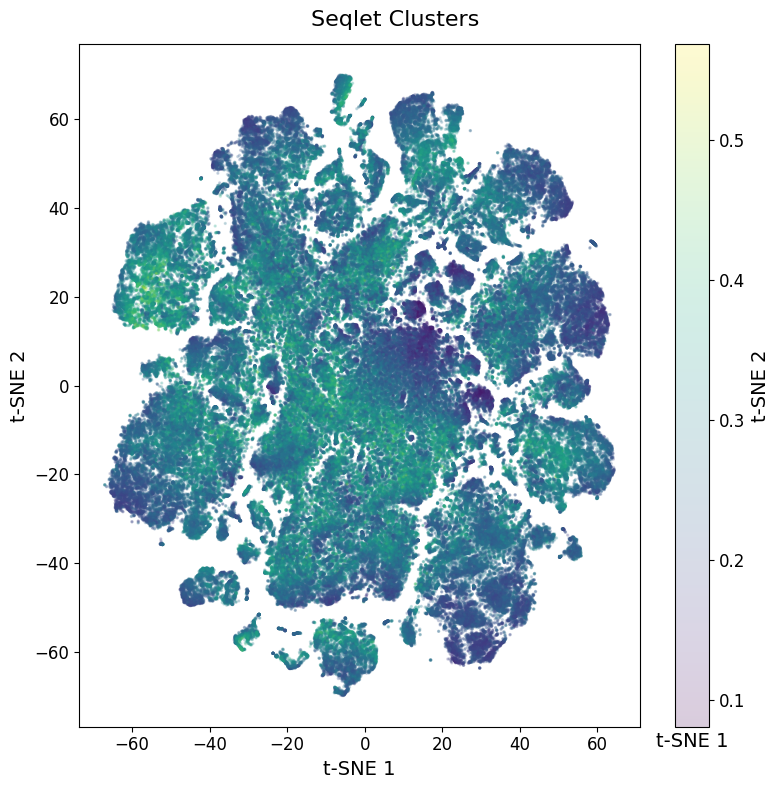

In [ ]:
%matplotlib inline
tm.pl.tsne(
    adata,
    color_by="mean_contrib",
    s=2,
    alpha=0.2,
    save_path=DATA_DIR + "seqlets_tsne_mean_contrib.png",
)

We can also visualize the TF family annotation, noisy seqlets won't have a TF annotation and will thus be annotated as "Unknown".

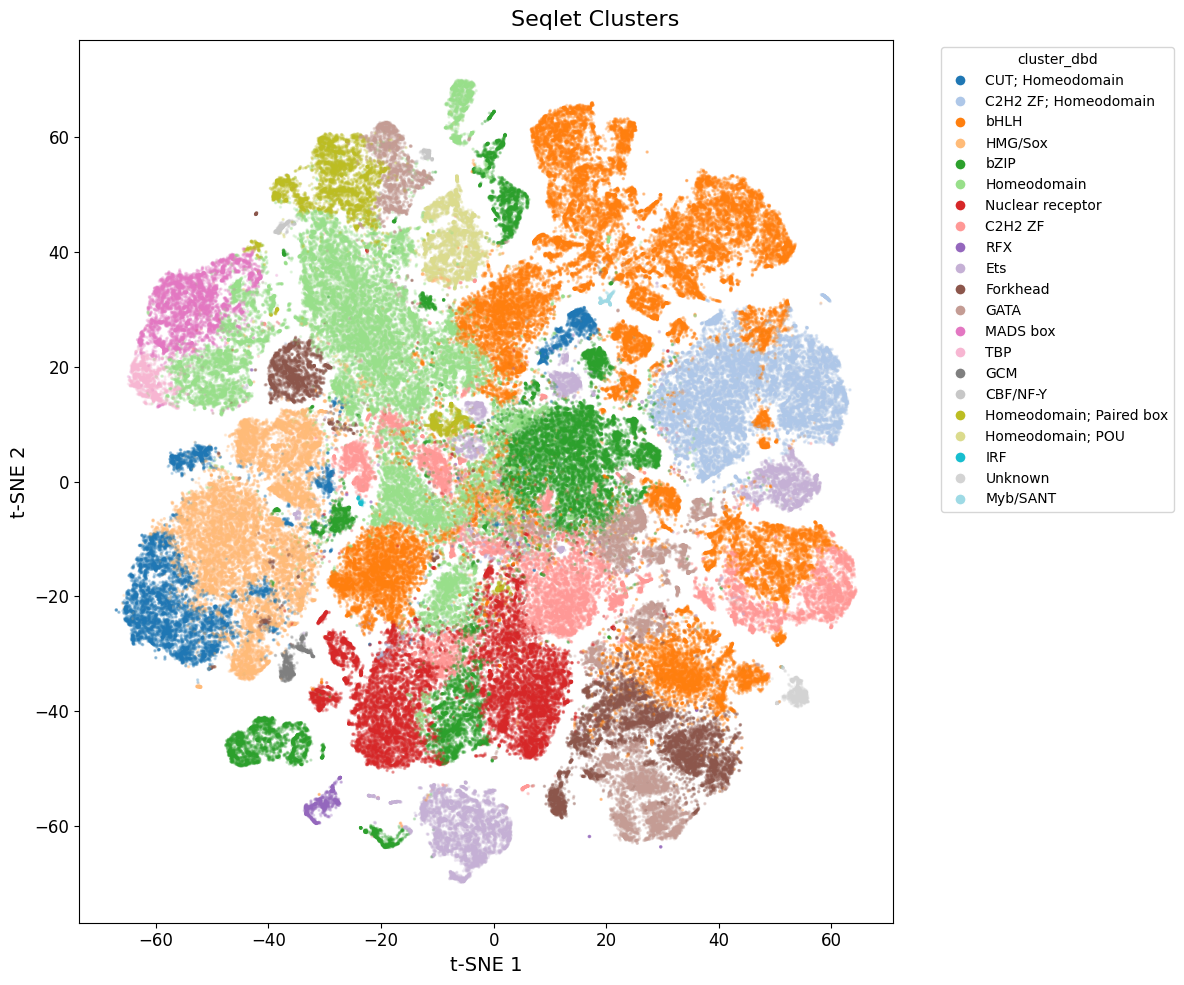

In [ ]:
tm.pl.tsne(
    adata,
    color_by="cluster_dbd",
    width=12,
    height=10,
    s=2,
    alpha=0.2,
    save_path=DATA_DIR + "seqlets_tsne_cluster_dbd.png",
)

In [10]:
tm.save_h5ad(adata, DATA_DIR + "seqlets_clustered.h5ad")

## Second round of clustering

Since we had a fairly strict significance threshold when calling our seqlets (0.01) and our cluster resolution was quite low, we don't have many "Unknown" seqlets clusters.  
Yet, it's still a good idea to omit the clusters that weren't annotated and perform clustering again on this "denoised" dataset. 

In [19]:
adata = tm.load_h5ad(DATA_DIR + "seqlets_clustered.h5ad")

In [20]:
adata_no_na = adata[~adata.obs["cluster_dbd"].isna()].copy()

In [21]:
tm.tl.cluster_seqlets(adata_no_na, resolution=20.0)

Computing PCA...
Computing neighborhood graph...


/home/VIB.LOCAL/lukas.mahieu/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing t-SNE embedding...
Performing Leiden clustering with resolution 20.0...
Clustering complete. Found 414 clusters.
DBD annotation coverage: 248124/254116 seqlets


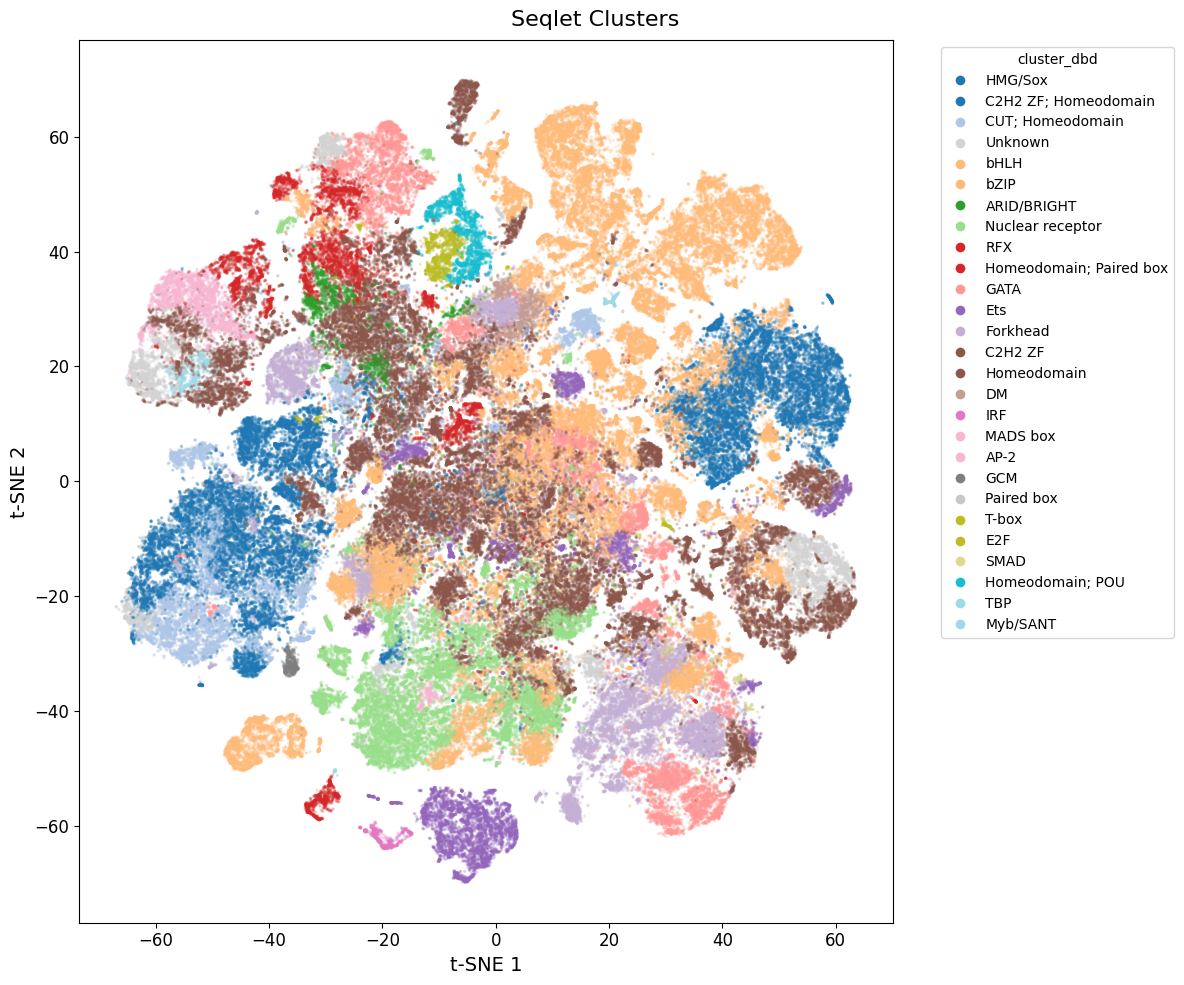

In [23]:
tm.pl.tsne(adata_no_na, color_by="cluster_dbd", width=12, height=10, s=2, alpha=0.2)

In [6]:
tm.save_h5ad(adata_no_na, DATA_DIR + "seqlets_clustered_no_na.h5ad")

## Generating Logos per cluster

Next, we will generate a logo for each cluster of seqlets. For this seqlets per cluster will be aligned using tomtom

In [2]:
adata_no_na = tm.load_h5ad(DATA_DIR + "seqlets_clustered_no_na.h5ad")

In [24]:
patterns = tm.tl.create_patterns(
    adata_no_na,
    max_n=500,  # sample n seqlets per cluster to speed things up
)

Creating patterns for 414 clusters...


These logo's can now be visualized. For example, on top of the tSNE of seqlets.

In [25]:
# example pattern associated with cluster 72
patterns["72"]

Pattern(cluster=72, n_seqlets=500, len=18, consensus='TAATGTCCAGACATAAAA', mean_ic=0.40, dbd=C2H2 ZF)

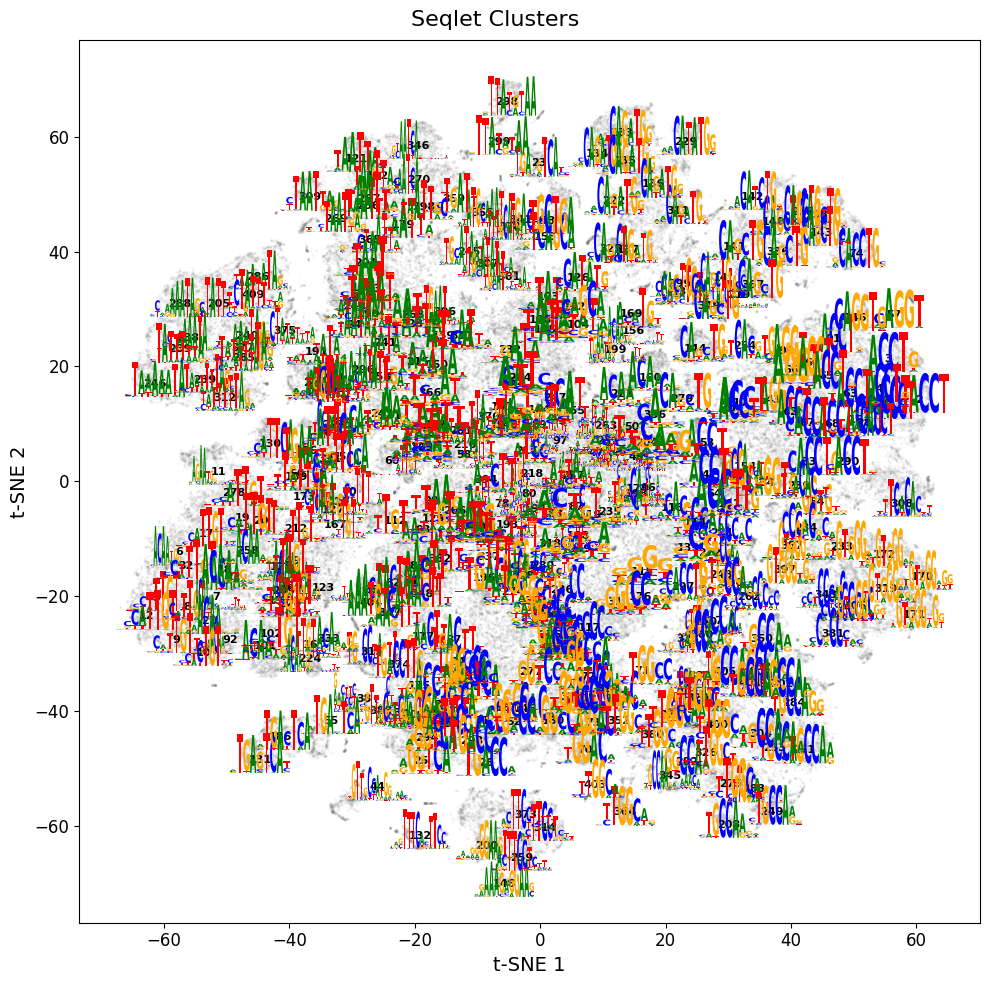

In [26]:
tm.pl.tsne_logos(
    adata_no_na,
    patterns,
    gray_background=True,  # ignore cmap and make all points gray for better visibility
    min_nucleotides=4,  # ignore trimmed patterns less than 4 nucleotides (heterogeneous clusters)
    width=10,
    height=10,
    s=0.5,
    alpha=0.05,
    logo_height=0.4,
    logo_width=0.6,
    ic_threshold=0.2,  # nucleotides in pattern below this will be trimmed
)

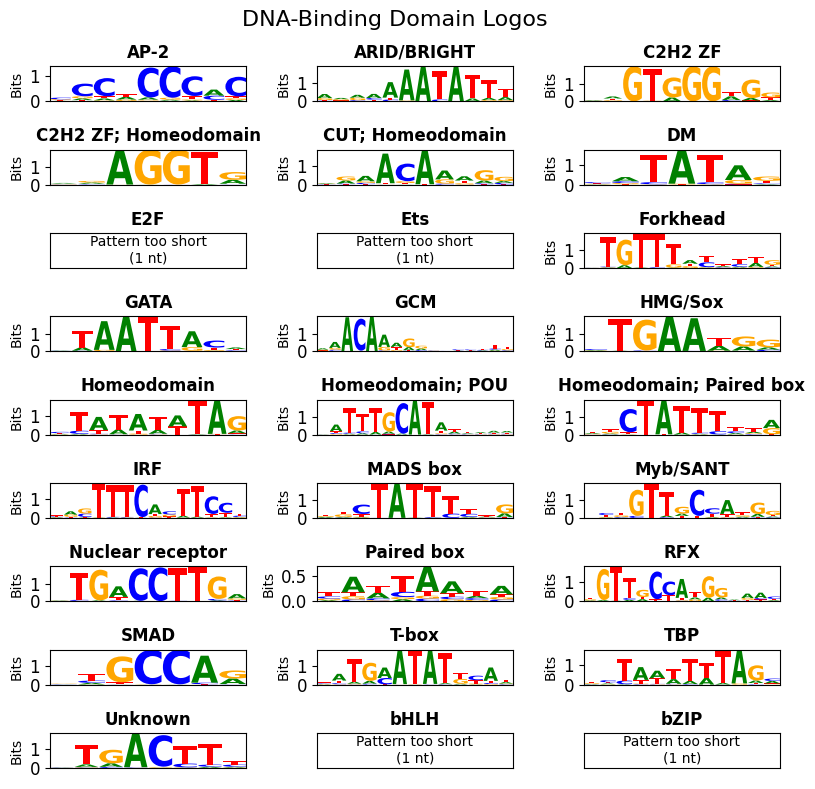

In [27]:
tm.pl.dbd_logos(patterns, ncols=3)

## Investigating DBD - Cell Type relationships

Since we know which seqlet came from which region, and we use regions that are specific to a certain cell type as inputs to the seqlet detection algorithm, we can link each seqlet to a specific cell type.
As we have annotated each seqlet with a DNA-binding-domain through the clusters, we can count the DBD occurence per cell type to investigate the relationship between the two.  
To do this, you need to have passed the `cell_type_mapping` argument when creating the original anndata object using `tm.pp.create_seqlet_adata`.  
Or, you can manually add this cell_type column in your anndata.obs. Then, you'll be able to plot a heatmap using `tm.pl.dbd_heatmap`.

In [6]:
adata_no_na.obs.head(3)  # 'cell_type' column needs to be present

example_idx  start   end  attribution       p-value  \
0        19895   1096  1121    42.909510 -1.230740e-10   
1        23086    962   979   -28.736305  5.394222e-08   
2        18255   1020  1038   -34.941820  8.111492e-08   

                                       seqlet_matrix  \
0  [[-0.08926726889774468, -0.10968999050528312, ...   
1  [[0.04017022574411184, 0.043687625802597996, 0...   
2  [[0.1571509604401175, -0.03379161693161631, 0....   

                                           seqlet_oh  \
0  [[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0,...   
1  [[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   

                                          example_oh  \
0  [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...   
1  [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
2  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                     example_contrib cell_type leiden  \
0  [[-2.4903556550270878e-05, 9.252861673303414e-...     Oligo      0   
1  [[5.913567292736843e-06, 1.5764757336000912e-0...       OPC      1   
2  [[-3.1602667704966336e-10, -1.83534280040476e-...     Oligo      1   

   mean_contrib seqlet_dbd           cluster_dbd  
0      0.299525        Rel               C2H2 ZF  
1      0.179667        NaN  C2H2 ZF; Homeodomain  
2      0.134993        NaN  C2H2 ZF; Homeodomain

/data/groups/vib.ai/stein.aerts/lmahieu/projects/TF-MInDi/src/tfmindi/pl/_utils.py:114: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


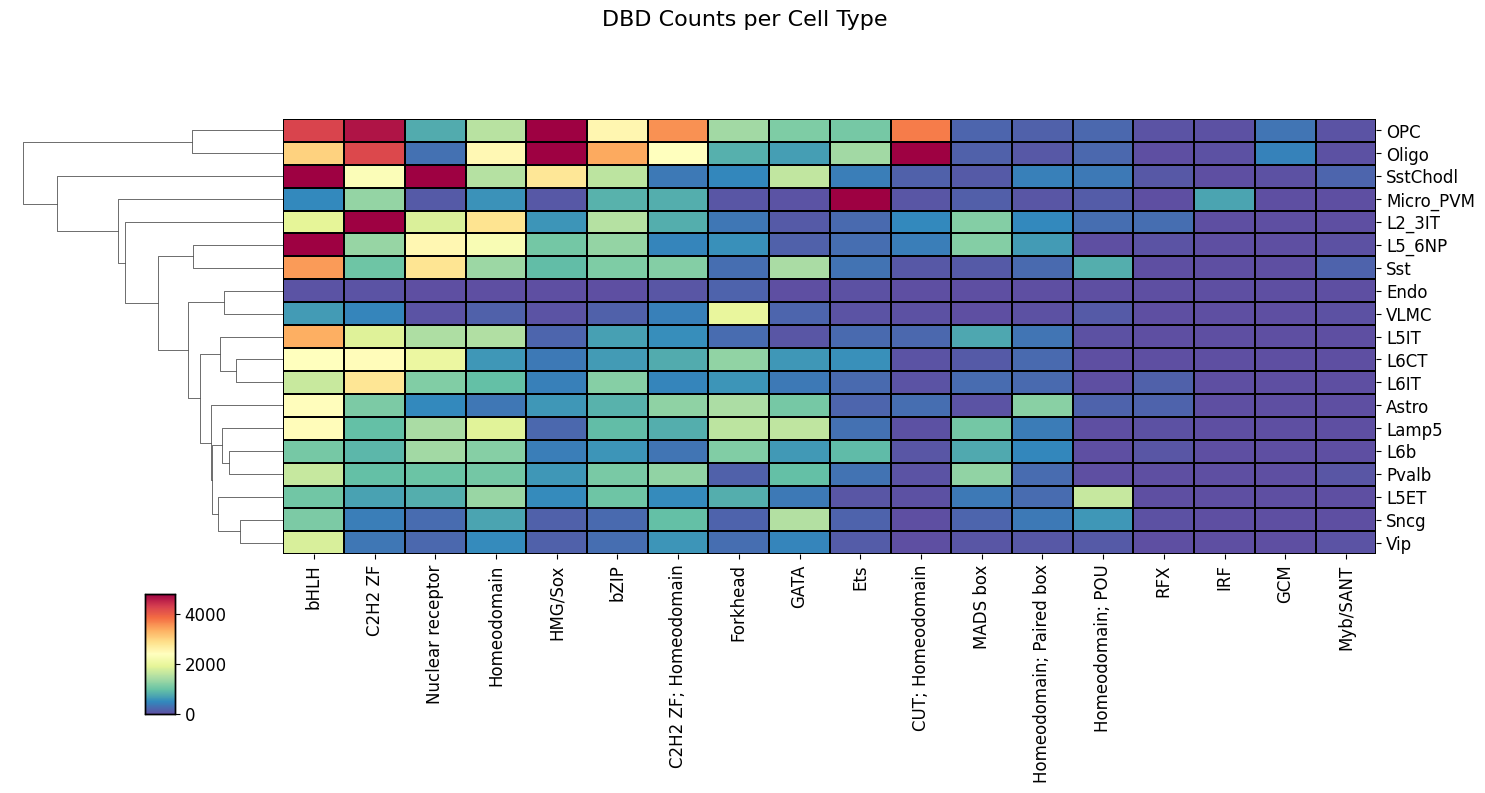

In [7]:
tm.pl.dbd_heatmap(adata_no_na, x_label_rotation=90, width=15, col_cluster=False)

## Annotating TF binding motif instances in genomic regions

As each seqlet is linked to a DBD now, it becomes trivial to highlight the TF binding motif instances in our original genomic regions.  

In [8]:
adata_no_na.obs

example_idx  start   end  attribution       p-value  \
0             19895   1096  1121    42.909510 -1.230740e-10   
1             23086    962   979   -28.736305  5.394222e-08   
2             18255   1020  1038   -34.941820  8.111492e-08   
3             19470   1013  1041    42.871715  1.851386e-07   
4             19577   1067  1092    43.687058  2.085394e-07   
...             ...    ...   ...          ...           ...   
254835        19518   1162  1173     1.902855  9.904238e-03   
254836         2308    885   896     2.826526  9.904238e-03   
254837        13290    940   951     2.854263  9.904238e-03   
254838         3966   1077  1088     2.360286  9.904238e-03   
254839        37677   1103  1115     3.215932  9.934528e-03   

                                            seqlet_matrix  \
0       [[-0.08926726889774468, -0.10968999050528312, ...   
1       [[0.04017022574411184, 0.043687625802597996, 0...   
2       [[0.1571509604401175, -0.03379161693161631, 0....   
3       [[0.011888066848427052, -0.035584272487547766,...   
4       [[-0.010883039240813314, -0.077614648090349, 0...   
...                                                   ...   
254835  [[-0.2466286429974181, 0.04168630177701599, 0....   
254836  [[-0.2295182803433148, 0.09578909396416145, -0...   
254837  [[0.5045523050828915, 0.29473411628280705, -0....   
254838  [[-0.07374752529903657, -0.009036704810377804,...   
254839  [[-0.1719538785893267, 0.11048431796617503, 0....   

                                                seqlet_oh  \
0       [[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0,...   
1       [[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
2       [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
3       [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
4       [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0,...   
...                                                   ...   
254835  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
254836  [[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0,...   
254837  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
254838  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
254839  [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                               example_oh  \
0       [[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0,...   
1       [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
2       [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3       [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...   
4       [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,...   
...                                                   ...   
254835  [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0,...   
254836  [[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0,...   
254837  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
254838  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...   
254839  [[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0,...   

                                          example_contrib cell_type leiden  \
0       [[-2.4903556550270878e-05, 9.252861673303414e-...     Oligo      0   
1       [[5.913567292736843e-06, 1.5764757336000912e-0...       OPC      1   
2       [[-3.1602667704966336e-10, -1.83534280040476e-...     Oligo      1   
3       [[8.473678576592647e-07, 1.0829913890120224e-0...     Oligo      8   
4       [[-6.21854256976917e-09, -1.6329009895343916e-...     Oligo     13   
...                                                   ...       ...    ...   
254835  [[1.5031736211312818e-07, 3.310746023998945e-0...     Oligo     10   
254836  [[-2.514610514481319e-06, 3.6886378893541405e-...      Sncg     28   
254837  [[4.399502813612344e-06, -1.7323827705695294e-...  SstChodl     66   
254838  [[7.551758471890935e-07, 5.3053663577884436e-0...      Sncg     72   
254839  [[1.8053902977044345e-06, 3.695597342812107e-0...      L5IT     64   

        mean_contrib seqlet_dbd              cluster_dbd  
0           0.299525        Rel                  C2H2 ZF

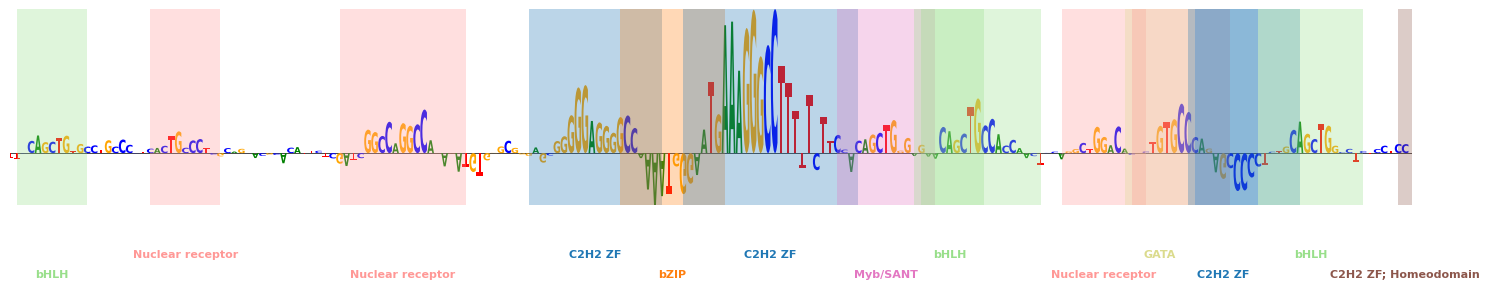

In [14]:
example_idx = 19895  # random region idx
tm.pl.region_contributions(
    adata_no_na,
    example_idx=example_idx,
    zoom_start=1000,
    zoom_end=1200,  # focus on 200bp
    min_attribution=1,  # ignore seqlets below this (absolute) threshold
)